# Test Double-DQN

In [22]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam
import gym
import random
import numpy as np

In [23]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
device = torch.device(device)

In [25]:
def plot(frame_idx, rewards, losses):
    %matplotlib inline
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Network and Loss Definitions

In [26]:
class QNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        self.num_actions = num_actions
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_size, 128),
                                nn.ReLU(),
                                nn.Linear(128, 128),
                                nn.ReLU(),
                                nn.Linear(128, num_actions))
    def forward(self, x):
        return self.fc(x)
    
    def get_value(self, state):
        return self.forward(state)
    
    def act(self, state, eps):
        if np.random.random() < eps:
            return np.random.randint(self.num_actions)
        return torch.argmax(self.forward(state)).item()

In [27]:
def synchronize_nets(from_net, to_net):
    to_net.load_state_dict(from_net.state_dict())

In [28]:
def ddqn_td_loss(online_net, target_net, batch, gamma=0.95):
    states, actions, rewards, dones, next_states = map(
        lambda arr: torch.as_tensor(arr, device=device, dtype=torch.float32), 
        batch
    )
    
    state_action_values = torch.gather(
        online_net.get_value(states), 1,
        actions.long().unsqueeze(-1)
    )
    
    online_next_state_values = online_net.get_value(next_states)
    best_online_actions = torch.argmax(online_next_state_values, dim=1)

    target_next_state_values = target_net.get_value(next_states)
    
    target_state_action_values = torch.gather(
        target_next_state_values, 1, 
        best_online_actions.unsqueeze(-1)
    )
    target_state_action_values *= 1.0 - dones.float().unsqueeze(-1)
    
    expected_state_action_values = rewards.unsqueeze(-1) + gamma * target_state_action_values
        
    loss = nn.MSELoss()(state_action_values, expected_state_action_values)
    return loss

In [29]:
from crar.experience import ReplayBuffer, Experience
from crar.utils import compute_eps

def play_step(replay_buffer, state, qnet, env, step_number, 
              eps_start=1.0, eps_end=0.01, eps_last_frame=1000):
    eps = compute_eps(step_number, eps_start, eps_end, eps_last_frame)
    action = qnet.act(
        torch.as_tensor(np.expand_dims(state, 0), device=device).float(),
        eps
    )
    next_state, reward, done, _ = env.step(action)
    exp = Experience(state, action, reward, done, next_state)
    replay_buffer.push(exp)
    
    return next_state, reward, done

In [30]:
def populate_warm_start(replay_buffer, qnet, env, eps_start=1.0, 
                        eps_end=0.001, eps_last_frame=1000):
    state = env.reset()
    for _ in range(1000):
        next_state, reward, done =\
            play_step(replay_buffer, state, qnet, env, 0)
        state = next_state
        if done:
            state = env.reset()

## CartPole

In [46]:
online_net = QNetwork(4, 2).to(device)
target_net = QNetwork(4, 2).to(device)

In [47]:
REPLAY_SIZE = 100
MAX_EP_LEN = 200
BATCH_SIZE = 32
SYNC_INTERVAL = 100
PLOT_INTERVAL = 100
TOTAL_STEPS = 2000

In [48]:
replay_buffer = ReplayBuffer(REPLAY_SIZE)

In [49]:
from crar.environments import TimeLimit

env_id = "CartPole-v0"
env = gym.make(env_id)
env = TimeLimit(env, MAX_EP_LEN)

In [50]:
populate_warm_start(replay_buffer, online_net, env)    

In [56]:
optimizer = torch.optim.Adam(online_net.parameters(), lr=1e-3)

In [57]:
def train_loop():
    state = env.reset()
    ep_rewards_list = []
    losses_list = []
    episode_reward = 0
    state = env.reset()
    for step_num in range(1, TOTAL_STEPS + 1):
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = ddqn_td_loss(online_net, target_net, batch)
            losses_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if step_num % SYNC_INTERVAL == 0:
            synchronize_nets(online_net, target_net)
        
        next_state, reward, done =\
            play_step(replay_buffer, state, online_net, env, step_num)
        episode_reward += reward
        state = next_state
        if done:
            ep_rewards_list.append(episode_reward)
            episode_reward = 0
            state = env.reset()
        if step_num % PLOT_INTERVAL == 0:
            plot(step_num, ep_rewards_list, losses_list)    
            

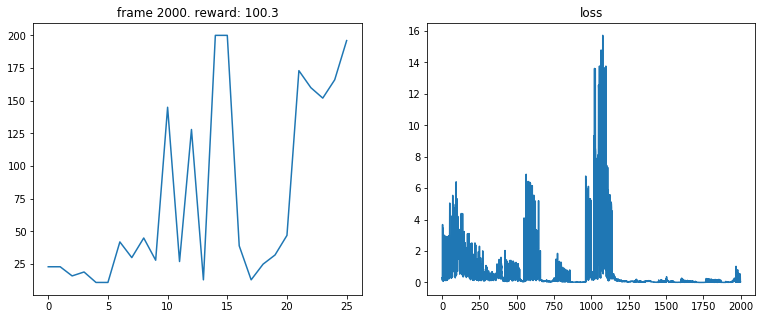

In [58]:
train_loop()